# Produce multiple global pathways


### Outputs
Lots of global total GHG excl LULUCF emissions pathway/pathways for commitments before a given date


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import os
from datetime import datetime
import itertools
import logging

import scmdata.database
from tqdm.autonotebook import tqdm

from ndcs.constants import PROCESSED_DATA_DIR, RAW_DATA_DIR, NDC_TARGET_RELEASE
from ndcs.pathways import NDCCruncher


<IPython.core.display.Javascript object>

/home/jared/miniconda3/envs/ndc-realisations-2021/lib/python3.9/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
COUNTRY_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "country_emissions", NDC_TARGET_RELEASE
)
GLOBAL_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "global_emissions_pathways", NDC_TARGET_RELEASE
)
BASELINE_SCENARIO = "SSP1BL"  # Used to fill countries which have not reported yet

<IPython.core.display.Javascript object>

In [5]:
country_db = scmdata.database.ScmDatabase(
    COUNTRY_DATABASE_DIR, levels=("region", "variable")
)
country_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../data/processed/country_emissions/12Nov2021a_CR, levels: ('region', 'variable'))>

<IPython.core.display.Javascript object>

In [6]:
global_db = scmdata.database.ScmDatabase(
    GLOBAL_DATABASE_DIR,
    levels=(
        "ambition",
        "conditionality",
        "country_extension",
        "exclude_hot_air",
        "pathway_id",
        "global_extension",
    ),
)
global_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../data/processed/global_emissions_pathways/12Nov2021a_CR, levels: ('ambition', 'conditionality', 'country_extension', 'exclude_hot_air', 'pathway_id', 'global_extension'))>

<IPython.core.display.Javascript object>

In [7]:
global_db.delete()

<IPython.core.display.Javascript object>

In [8]:
raw_country_emms = country_db.load(
    variable="Emissions|Total GHG excl. LULUCF|*"
).filter(country_extension="SSP5BL", keep=False)
len(raw_country_emms.get_unique_meta("region"))

Loading files:   0%|          | 0/990 [00:00<?, ?it/s]

198

<IPython.core.display.Javascript object>

In [9]:
raw_country_emms.get_unique_meta("country_extension")

['SSP1BL', 'constant', '2030', 'rate']

<IPython.core.display.Javascript object>

In [10]:
raw_country_emms = raw_country_emms.filter(
    country_extension=["SSP1BL", "2030"], conditionality=["C", "U"]
)

<IPython.core.display.Javascript object>

In [11]:
raw_country_emms.meta[
    ["ambition", "country_extension", "conditionality"]
].drop_duplicates()

,ambition,country_extension,conditionality
0,high,SSP1BL,C
4,high,SSP1BL,U
6,low,SSP1BL,C
10,low,SSP1BL,U
72,high,2030,C
76,high,2030,U
78,low,2030,C
82,low,2030,U


<IPython.core.display.Javascript object>

In [12]:
baseline_country_emms = country_db.load(variable="Emissions|Total GHG*").filter(
    scenario=BASELINE_SCENARIO
)
len(baseline_country_emms.get_unique_meta("region"))

Loading files:   0%|          | 0/1386 [00:00<?, ?it/s]

198

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2/yr'>

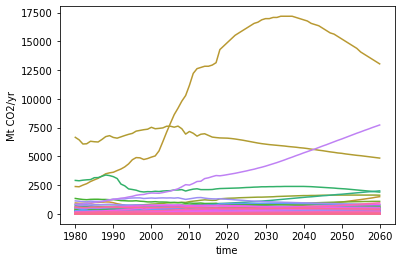

<IPython.core.display.Javascript object>

In [13]:
baseline_country_emms.lineplot(hue="region", legend=False)

In [14]:
# We have to scale the SSP1BL emissions to match the countries historical values
# This is also done in 220
SCALE_YEAR = 2015

baseline_adjusted_emms = []


targets = raw_country_emms.filter(
    scenario="HighNDC",
    conditionality="C",
    country_extension="SSP1BL",
    exclude_hot_air="include",
    year=SCALE_YEAR,
)
for r in baseline_country_emms.get_unique_meta("region"):
    region_emms = baseline_country_emms.filter(region=r)

    scale_factor = (
        targets.filter(region=r).values.squeeze()
        / region_emms.filter(year=SCALE_YEAR).values.squeeze()
    )

    baseline_adjusted_emms.append(region_emms * scale_factor)
baseline_adjusted_emms = scmdata.run_append(baseline_adjusted_emms)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2/yr'>

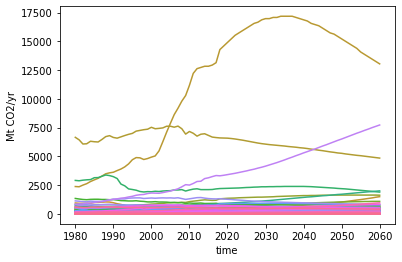

<IPython.core.display.Javascript object>

In [15]:
baseline_adjusted_emms.lineplot(hue="region", legend=False)

In [16]:
raw_country_emms.filter(
    scenario="HighNDC",
    conditionality="C",
    country_extension="SSP1BL",
    exclude_hot_air="exclude",
    year=2015,
).timeseries().sum()

time
2015-01-01    48223.28657
dtype: float64

<IPython.core.display.Javascript object>

In [17]:
baseline_adjusted_emms.filter(scenario=BASELINE_SCENARIO, year=2015).timeseries().sum()

time
2015-01-01    48223.28657
dtype: float64

<IPython.core.display.Javascript object>

In [18]:
raw_country_emms

<scmdata.ScmRun (timeseries: 6328, timepoints: 61)>
Time:
	Start: 1990-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	      ambition conditionality country_extension exclude_hot_air  last_provided_year          model region        scenario submission_date        unit                                 variable
	0         high              C            SSP1BL         exclude                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	1         high              C            SSP1BL         include                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	4         high              U            SSP1BL         exclude                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	5         high              U            SSP1BL         include                2030  NDC Factsheet    TUV  HighIn

<IPython.core.display.Javascript object>

In [19]:
country_emms = raw_country_emms.copy()

<IPython.core.display.Javascript object>

In [20]:
update_dates = (
    ("ZZA", True, "7/18/2013"),
    ("ZZB", True, "7/18/2013"),
    ("LBY", True, "7/18/2013"),
    ("ZZA", False, "10/4/2019"),
    ("ZZB", False, "4/30/2018"),
)

for region, is_initial, date in update_dates:
    scenario = (
        ["HighInitialNDC", "LowInitialNDC"] if is_initial else ["HighNDC", "LowNDC"]
    )
    subset = country_emms.filter(region=region, scenario=scenario)
    subset["submission_date"] = date

    country_emms = scmdata.run_append(
        [country_emms.filter(region=region, scenario=scenario, keep=False), subset]
    )

<IPython.core.display.Javascript object>

In [21]:
# Drop the duplicated timeseries for countries which have not reported an updated NDC yet
country_emms = country_emms.filter(submission_date="NOT YET", keep=False)

<IPython.core.display.Javascript object>

In [22]:
len(country_emms.filter(variable="Emissions|Total GHG excl. LULUCF|SSP1BL"))

2828

<IPython.core.display.Javascript object>

In [23]:
raw_country_emms.filter(region="IND").get_unique_meta("submission_date")

['10/2/2016', '11/1/2021']

<IPython.core.display.Javascript object>

# Preprocessing
* Convert SubmissionDate to something we can filter by

In [24]:
country_emms["submission_date"] = [
    datetime.strptime(d, "%m/%d/%Y").date() for d in country_emms["submission_date"]
]
country_emms = country_emms.resample("AS").filter(year=range(2010, 2051))

<IPython.core.display.Javascript object>

In [25]:
baseline_adjusted_emms = baseline_adjusted_emms.resample("AS").filter(
    year=range(2010, 2051)
)

<IPython.core.display.Javascript object>

# Merge available scenarios

Given a set of submitted NDCs, merge to form a single global path. If a country has not yet submitted, add emissions from SSP1 or SSP5

In [26]:
%pdb off

Automatic pdb calling has been turned OFF


<IPython.core.display.Javascript object>

In [27]:
def process_all_ndcs(conditionality, ambition, country_extension, exclude_hot_air):
    cruncher = NDCCruncher(global_db, country_emms, baseline_adjusted_emms, conditionality, ambition, country_extension, exclude_hot_air)
    cruncher.crunch()


<IPython.core.display.Javascript object>

In [28]:
options = list(
    itertools.product(
        country_emms.get_unique_meta("conditionality"),
        country_emms.get_unique_meta("ambition"),
        country_emms.get_unique_meta("country_extension"),
        country_emms.get_unique_meta("exclude_hot_air"),
    )
)
options

[('C', 'high', 'SSP1BL', 'exclude'),
 ('C', 'high', 'SSP1BL', 'include'),
 ('C', 'high', '2030', 'exclude'),
 ('C', 'high', '2030', 'include'),
 ('C', 'low', 'SSP1BL', 'exclude'),
 ('C', 'low', 'SSP1BL', 'include'),
 ('C', 'low', '2030', 'exclude'),
 ('C', 'low', '2030', 'include'),
 ('U', 'high', 'SSP1BL', 'exclude'),
 ('U', 'high', 'SSP1BL', 'include'),
 ('U', 'high', '2030', 'exclude'),
 ('U', 'high', '2030', 'include'),
 ('U', 'low', 'SSP1BL', 'exclude'),
 ('U', 'low', 'SSP1BL', 'include'),
 ('U', 'low', '2030', 'exclude'),
 ('U', 'low', '2030', 'include')]

<IPython.core.display.Javascript object>

In [29]:
logger = logging.getLogger("nb")

<IPython.core.display.Javascript object>

In [30]:
from concurrent.futures import as_completed, ProcessPoolExecutor
import time

pool = ProcessPoolExecutor(
    max_workers=16,
)
futures = [pool.submit(process_all_ndcs, *a) for a in options]

logger.info("Waiting for jobs to complete")
for i, future in tqdm(
    enumerate(as_completed(futures)), total=len(futures), desc="options"
):
    if future.exception() is not None:
        time.sleep(2)  # let buffer flush out
        print(
            "One of the processes failed, see error below (was something "
            "unable to be pickled?)"
        )
        raise future.exception()

res = []
logger.info("Collecting results")
for i, future in enumerate(futures):
    try:
        res.append(future.result())
    except Exception as exc:  # pylint:disable=broad-except
        res.append(exc)

options:   0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [31]:
global_emms = global_db.load()

Loading files:   0%|          | 0/5656 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [32]:
global_emms.head()

time                                                                                                                                                                                                                       2010-01-01    2011-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                       
high     C              2030              2021-08-02 exclude         n/a              COG          NDC Factsheet 2021-08-02_1 309         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590  46428.064370   
                                          2021-10-10 exclude         n/a              PSE          NDC Factsheet 2021-10-10_1 325         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590  46428.064370   
                                          2021-04-16 exclude         n/a              MKD          NDC Factsheet 2021-04-16_1 277         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590  46428.064370   
                                          2018-11-30 exclude         n/a              SYR          NDC Factsheet 2018-11-30_1 193         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45113.146990  46470.336655   
                                          2020-12-09 exclude         n/a              NPL          NDC Factsheet 2020-12-09_3 219         3                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45086.288422  46429.675899   

time                                                                                                                                                                                                                       2012-01-01    2013-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                       
high     C              2030              2021-08-02 exclude         n/a              COG          NDC Factsheet 2021-08-02_1 309         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  47088.761910  47449.275490   
                                          2021-10-10 exclude         n/a              PSE          NDC Factsheet 2021-10-10_1 325         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  47088.761910  47449.275490   
                                          2021-04-16 exclude         n/a              MKD          NDC Factsheet 2021-04-16_1 277         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  47088.761910  47449.275490   
                                          2018-11-30 exclude         n/a              SYR          NDC Factsheet 2018-11-30_1 193         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  47123.611817  47477.588909   
                                          2020-12-09 exclude         n/a              NPL          NDC Factsheet 2020-12-09_3 219         3                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  47088.695037  47448.032521   

time                                                                                                                                                                                                                       2014-01-01   2015-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                      
high     C              2030              2021-0

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 /yr'>

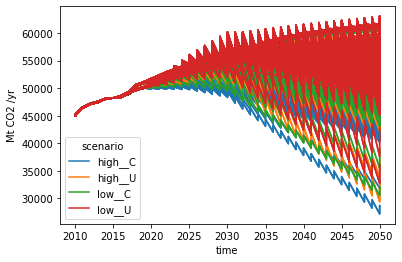

<IPython.core.display.Javascript object>

In [33]:
global_emms.filter(country_extension="SSP1BL").lineplot(
    hue="scenario", units="pathway_id", estimator=None
)

In [34]:
pathways = global_emms.timeseries().sort_index(level="pathway_id")
pathways

time                                                                                                                                                                                                                       2010-01-01    2011-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                       
high     C              2030              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                        SSP1BL            2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
         U              2030              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                        SSP1BL            2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
low      C              2030              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443  46616.881205   
...                                                                                                                                                                                                                               ...           ...   
high     U              SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590  46428.064370   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 352         1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45084.611974  46427.121255   
low      C              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590  46428.064370   
                                                

<IPython.core.display.Javascript object>

In [37]:
latest_pathway = max(global_emms.get_unique_meta("pathway_num"))
latest_pathway

354

<IPython.core.display.Javascript object>

In [42]:
global_emms.filter(pathway_num=latest_pathway).timeseries()

time                                                                                                                                                                                                                      2010-01-01   2011-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                     
high     C              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__C  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
         U              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  high__U  Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
low      C              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__C   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
         U              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__U   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  low__U   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559  46428.06437   

time                                                                                                                                                                                                                      2012-01-01   2013-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario unit       variable                                                     
high     C              2030              2021-11-09 exclude         n/a       

<IPython.core.display.Javascript object>